In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os

def is_categorical(series, threshold=10):
    return series.nunique() <= threshold or series.dtype == 'object'

def plot_all_features(
    df,
    features,
    target_col,
    n_bins=3,
    max_cols=2,
    figsize=(14, 5),
    normalize_target=False,
    bar_color='skyblue',
    line_color='red',
    marker='o',
    save_path=None  # e.g., 'output_graphs.pdf' or 'graphs.png'
):
    num_features = len(features)
    num_rows = math.ceil(num_features / max_cols)

    fig, axes = plt.subplots(num_rows, max_cols, figsize=(figsize[0], figsize[1] * num_rows))
    if num_features == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, feature in enumerate(features):
        ax1 = axes[idx]
        ax2 = ax1.twinx()

        df_valid = df[[feature, target_col]].dropna()

        try:
            # target 정규화 옵션
            if normalize_target:
                min_val = df_valid[target_col].min()
                max_val = df_valid[target_col].max()
                if max_val > min_val:
                    df_valid[target_col] = (df_valid[target_col] - min_val) / (max_val - min_val)

            # 범주형 처리
            if is_categorical(df_valid[feature]):
                grouped = df_valid.groupby(feature).agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()
                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped[feature].astype(str)

            # 연속형 처리
            else:
                df_valid['bin'] = pd.qcut(df_valid[feature], q=n_bins, duplicates='drop')
                grouped = df_valid.groupby('bin').agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()
                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped['bin'].astype(str)

            # Bar (user ratio)
            ax1.bar(x_vals, grouped['user_ratio'], color=bar_color)
            ax1.set_ylabel('user ratio')

            # Line (target_rate)
            ax2.plot(x_vals, grouped['target_rate'], color=line_color, marker=marker)
            ax2.set_ylabel('target_rate', color=line_color)

            ax1.set_title(f"target_rate by {feature}")
            ax1.tick_params(axis='x', rotation=45)

        except Exception as e:
            ax1.set_title(f"{feature} - 오류 발생")
            print(f"[ERROR] '{feature}' 처리 중 오류: {e}")

    # 나머지 subplot 비우기
    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()

    # 저장
    if save_path:
        dirname = os.path.dirname(save_path)
        if dirname and not os.path.exists(dirname):
            os.makedirs(dirname)
        fig.savefig(save_path, dpi=300)
        print(f"✅ 그래프 저장 완료: {save_path}")

    plt.show()


# 샘플 데이터
df = pd.DataFrame({
    'price': np.random.uniform(0, 300, 500),
    'period': np.random.randint(0, 1000, 500),
    'product_type': np.random.choice(['A', 'B', 'C'], 500),
    'channel': np.random.choice(['online', 'offline'], 500),
    'age': np.random.randint(20, 70, 500),
    'target': np.random.choice([0, 1], 500, p=[0.8, 0.2])
    # 'target': np.random.normal(0.1, 0.05, 500)  # 예: 확률형 타겟
})

# 시각화
plot_all_features(
    df,
    features=['price', 'period', 'product_type', 'channel', 'age'],
    target_col='target',
    n_bins=3,
    normalize_target=True,
    bar_color='skyblue',
    line_color='darkorange',
    marker='s',
    save_path='output/feature_visuals.png'
)


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

def is_categorical(series, threshold=10):
    """범주형 판단: 고유값 개수 기준"""
    return series.nunique() <= threshold or series.dtype == 'object'

def plot_all_features(df, features, target_col, n_bins=3, max_cols=2, figsize=(14, 5)):
    """
    연속형 + 범주형 변수 모두 subplot으로 시각화
    """
    num_features = len(features)
    num_rows = math.ceil(num_features / max_cols)

    fig, axes = plt.subplots(num_rows, max_cols, figsize=(figsize[0], figsize[1] * num_rows))
    if num_features == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, feature in enumerate(features):
        ax1 = axes[idx]
        ax2 = ax1.twinx()

        df_valid = df[[feature, target_col]].dropna()

        try:
            # --- 범주형 피처 처리 ---
            if is_categorical(df_valid[feature]):
                grouped = df_valid.groupby(feature).agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()
                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped[feature].astype(str)

            # --- 연속형 피처 처리 ---
            else:
                df_valid['bin'] = pd.qcut(df_valid[feature], q=n_bins, duplicates='drop')
                grouped = df_valid.groupby('bin').agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()
                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped['bin'].astype(str)

            # bar plot
            ax1.bar(x_vals, grouped['user_ratio'], color='skyblue')
            ax1.set_ylabel('user ratio')

            # line plot
            ax2.plot(x_vals, grouped['target_rate'], color='black', marker='o')
            ax2.set_ylabel('target_rate', color='black')

            ax1.set_title(f"target_rate by {feature}")
            ax1.tick_params(axis='x', rotation=0)

        except Exception as e:
            ax1.set_title(f"{feature} - 오류 발생")
            print(f"[ERROR] {feature}: {e}")
            continue

    # 나머지 subplot 빈칸 숨기기
    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# 예시 데이터
df = pd.DataFrame({
    'price': np.random.uniform(0, 300, 500),
    'period': np.random.randint(0, 1000, 500),
    'product_type': np.random.choice(['A', 'B', 'C'], 500),
    'channel': np.random.choice(['online', 'offline'], 500),
    'age': np.random.randint(20, 70, 500),
    'target': np.random.choice([0, 1], 500, p=[0.8, 0.2])
})

# 피처 리스트 (연속형 + 범주형 혼합)
features = ['price', 'period', 'product_type', 'channel', 'age']

# 실행
plot_all_features(df, features, target_col='target', n_bins=3, max_cols=2)


# 다중공선성(VIF: Variance Inflation Factor) 계산
* 하나의 피처가 다른 피처들과 얼마나 선형 종속적인지를 측정
* VIF > 5 또는 10이면 해당 변수가 다른 변수들과 심하게 상관되어 있다는 의미 → 과적합 위험, 회귀계수 해석 왜곡

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from sklearn.preprocessing import StandardScaler

def calculate_vif(X: pd.DataFrame):
    """
    VIF(Variance Inflation Factor)를 계산하여 다중공선성 진단
    Parameters:
        X: 독립변수만 포함된 DataFrame
    Returns:
        VIF 결과 DataFrame
    """
    X_scaled = StandardScaler().fit_transform(X)  # 스케일링 권장
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

X = df.select_dtypes(include=['float', 'int']).drop(columns=['target'])
vif_result = calculate_vif(X)
print(vif_result)

  feature       VIF
1  period  1.003525
2     age  1.003215
0   price  1.001307


# 연속형 변수의 monotonicity 검사
* 특정 피처 값이 증가할수록 타겟(예: 구매확률, 이탈확률 등)이 일정한 방향으로 변하는가?
* 특히 로지스틱 회귀, 신용평가, 리스크 모델 등에서는 **단조성(monotonicity)**을 강하게 요구함

In [16]:

def check_monotonicity(df, feature_list, target_col):
    """
    연속형 변수의 단조성(모노토닉 관계) 평가 - Spearman 순위 상관계수 기준
    """
    results = []
    for feature in feature_list:
        corr = df[[feature, target_col]].dropna().corr(method='spearman').iloc[0, 1]
        results.append({'feature': feature, 'spearman_corr': corr})
    return pd.DataFrame(results).sort_values('spearman_corr', key=abs, ascending=False)

continuous_features = df.select_dtypes(include=['float', 'int']).drop(columns='target').columns
monotonic_result = check_monotonicity(df, continuous_features, target_col='target')
print(monotonic_result)

import seaborn as sns
import matplotlib.pyplot as plt

def plot_monotonicity(df, feature, target_col, bins=10):
    df = df[[feature, target_col]].dropna()
    df['bin'] = pd.qcut(df[feature], q=bins, duplicates='drop')
    summary = df.groupby('bin')[target_col].mean().reset_index()

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=summary, x='bin', y=target_col, marker='o')
    plt.xticks(rotation=45)
    plt.title(f"{feature} vs. {target_col} (Monotonicity Check)")
    plt.tight_layout()
    plt.show()

  feature  spearman_corr
0   price       0.097307
1  period      -0.053763
2     age      -0.022877


📊 [Kolmogorov–Smirnov] D=0.3412, p=0.0000
📊 [Mann–Whitney U]     U=40860.0000, p=0.0000


/tmp/ipython-input-17-2106819784.py:45: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-2106819784.py:45: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-2106819784.py:45: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-2106819784.py:45: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-2106819784.py:45: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-2106819784.py:45: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-2106819784.py:45: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  p

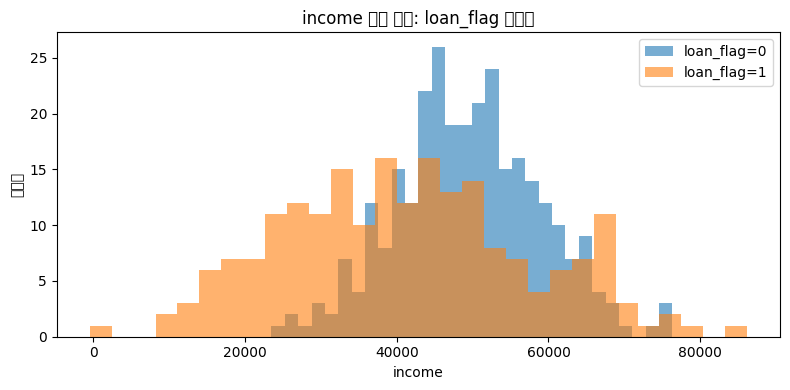

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, mannwhitneyu
import matplotlib.pyplot as plt

# -----------------------------
# 1. 샘플 데이터 생성
# -----------------------------
np.random.seed(42)

n = 500
df = pd.DataFrame({
    'loan_flag': np.random.choice([0, 1], size=n, p=[0.6, 0.4]),
})

# 대출이 없는 사람은 평균 소득이 높고, 대출 있는 사람은 낮게 설정
df['income'] = df['loan_flag'].apply(lambda x:
                                     np.random.normal(50000, 10000) if x == 0
                                     else np.random.normal(40000, 15000))

# -----------------------------
# 2. KS & Mann–Whitney U 검정 함수 정의
# -----------------------------
def compare_distributions(df, group_col, value_col, group_values=None, plot=True):
    if group_values is None:
        group_values = df[group_col].dropna().unique()[:2]

    group1 = df[df[group_col] == group_values[0]][value_col].dropna()
    group2 = df[df[group_col] == group_values[1]][value_col].dropna()

    ks_stat, ks_p = ks_2samp(group1, group2)
    u_stat, u_p = mannwhitneyu(group1, group2, alternative='two-sided')

    print(f"📊 [Kolmogorov–Smirnov] D={ks_stat:.4f}, p={ks_p:.4f}")
    print(f"📊 [Mann–Whitney U]     U={u_stat:.4f}, p={u_p:.4f}")

    if plot:
        plt.figure(figsize=(8, 4))
        plt.hist(group1, bins=30, alpha=0.6, label=f'{group_col}={group_values[0]}')
        plt.hist(group2, bins=30, alpha=0.6, label=f'{group_col}={group_values[1]}')
        plt.xlabel(value_col)
        plt.ylabel('빈도수')
        plt.title(f'{value_col} 분포 비교: {group_col} 그룹별')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {
        'ks_stat': ks_stat,
        'ks_pvalue': ks_p,
        'u_stat': u_stat,
        'u_pvalue': u_p
    }

# -----------------------------
# 3. 테스트 실행
# -----------------------------
results = compare_distributions(df, group_col='loan_flag', value_col='income')